In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True,
                            download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                           download=True, transform=transform)

num_workers = 0
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [3]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
        return x

In [4]:
model = ConvAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
n_epochs = 10
for epoch in range(n_epochs):
    train_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

Epoch 1, Loss: 0.0247
Epoch 2, Loss: 0.0140
Epoch 3, Loss: 0.0132
Epoch 4, Loss: 0.0126
Epoch 5, Loss: 0.0122
Epoch 6, Loss: 0.0119
Epoch 7, Loss: 0.0117
Epoch 8, Loss: 0.0115
Epoch 9, Loss: 0.0113
Epoch 10, Loss: 0.0112


In [7]:
model.eval()
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

with torch.no_grad():
    outputs = model(images)

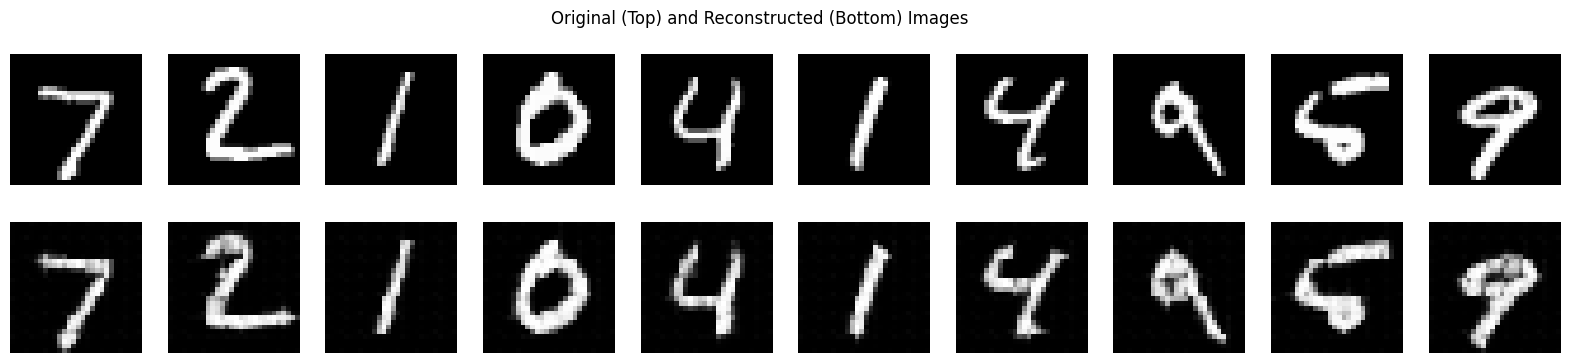

In [10]:
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

for idx in range(10):
    ax = axes[0, idx]
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.axis('off')

for idx in range(10):
    ax = axes[1, idx]
    ax.imshow(np.squeeze(outputs[idx]), cmap='gray')
    ax.axis('off')

plt.suptitle("Original (Top) and Reconstructed (Bottom) Images")
plt.show()